In [1]:
import scanpy as sc
import pandas as pd #only one needed if you have your labels already
import numpy as np
from matplotlib.pyplot import rc_context

In [2]:
## NONE OF THIS IS NEEDED for RANDOM FOREST IF YOU HAVE YOUR LABELS ALREADY ##
adata = sc.read_10x_mtx('tutorial_sample/outs/filtered_feature_bc_matrix/',var_names='gene_symbols',cache=True)
#pp
sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20]
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(adata) #change to log counts


#clustering
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
adata.raw = adata #save raw data before processing values and further filtering
adata = adata[:, adata.var.highly_variable] #filter highly variable
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.25)

/home/jrlab2019/miniconda3/envs/geo/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/jrlab2019/miniconda3/envs/geo/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jrlab2019/miniconda3/envs/geo/lib/python3.10/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
2022-02-19 15:51:38.951800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open s

In [3]:
## NOT NEEDED FOR RF, SPECIFIC TO MY ANALYSIS ##
#find Zika positive cells
zik_i = np.where(adata.raw.var_names == 'zika')[0][0]
zik = adata.raw.X.toarray()[:,zik_i]
zik_l = zik.copy()

q95 = np.quantile(zik, 0.95)
zik_l[zik_l < q95] = 0
zik_l[zik_l > 0] = 1
adata.obs['Zika'] = zik #normalized raw UMI count
adata.obs['Zika_q95'] = zik_l #0 or 1 based on if count is >= q95

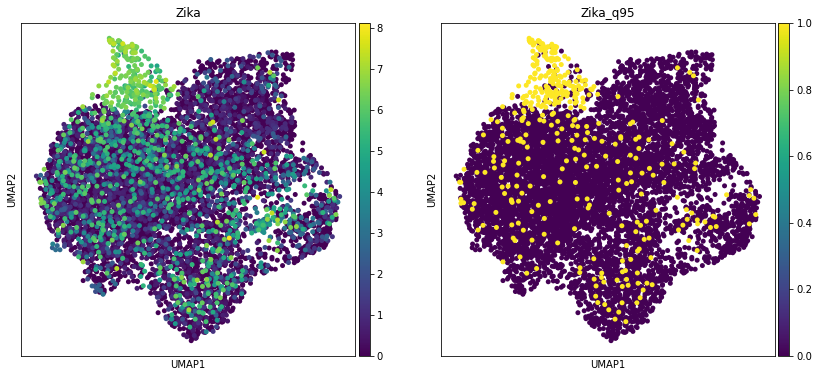

In [4]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['Zika', 'Zika_q95'], s = 100)

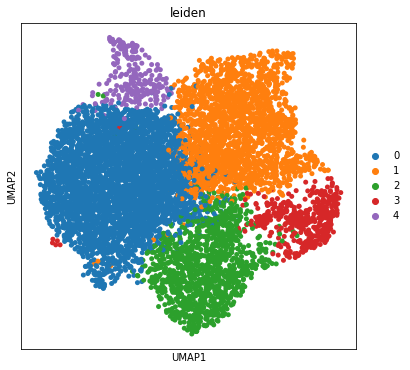

In [5]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['leiden'], s = 100)

In [6]:
## EXAMPLE OF LABELING A SPECEFIC SUBPOPULATION BASED ON CLUSTER ##

#we want to label cluster 4 with 1 and the rest with 0
def is_it_what_i_want(x):
    if x == '4': #leiden column is string
        return 1
    else:
        return 0

In [7]:
adata.obs['c_label'] = adata.obs.leiden.map(is_it_what_i_want)

In [8]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,Zika,Zika_q95,c_label
AAACCCAAGGGCAATC-1,3243,3243,8900.0,5.0,0.056180,2,0.000000,0.0,0
AAACCCAAGTATAGAC-1,5443,5443,25977.0,1477.0,5.685799,1,0.325668,0.0,0
AAACCCACAACGCATT-1,5159,5159,21172.0,1035.0,4.888532,2,0.386841,0.0,0
AAACCCACACGCGCAT-1,5991,5991,26725.0,1724.0,6.450889,2,5.798806,1.0,0
AAACCCAGTAAGATCA-1,2599,2599,6490.0,242.0,3.728814,2,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTGTGTA-1,2215,2215,6958.0,74.0,1.063524,1,0.000000,0.0,0
TTTGTTGCAGATTTCG-1,1579,1579,5194.0,9.0,0.173277,3,0.000000,0.0,0
TTTGTTGGTCGTCTCT-1,4111,4111,14611.0,631.0,4.318664,0,4.436737,0.0,0
TTTGTTGGTGTAACGG-1,2556,2555,9147.0,221.0,2.416093,1,0.000000,0.0,0


In [ ]:
###THIS WAS R SCRIPT TO RUN BITFAM, DONT RUN THIS BLOCK IN NOTEBOOK###
#!/usr/bin/env Rscript
library(Seurat)
library(BITFAM)
mtx <- Read10X('../tutorial_sample/outs/filtered_feature_bc_matrix')
mtx <- BITFAM_preprocess(raw_data = mtx)
res <- BITFAM(data = mtx, species = 'human', scATAC_obj = NA, ncores = parallel::detectCores())
Z <- BITFAM_activities(res)
write.table(Z, file = 'BITFAM_out.csv', sep = ",")

In [ ]:
#if you did your analysis in seruat but wanted to do TF in python, export the seurat metadata as a csv and open
#it up in pandas

In [ ]:
#START BITFAM + random forest

In [9]:
import pandas as pd

In [12]:
z = pd.read_csv('BITFAM/BITFAM_out.csv')
z = z[z.index.isin(adata.obs.index)]

In [16]:
z.head()

,HAND1,SOX11,ID2,SOX4,ATF3,ID3,MYC,MSX1,ID1,FOSB,...,CUL4A,CUX1,ZFHX2,NR3C1,KAT2A,SIX2,HIVEP1,ZNF329,NCOA6,ZBTB6
AAACCCAAGGGCAATC-1,0.047190,0.011339,0.014070,0.006275,0.006819,0.013039,0.008783,0.021430,0.023967,0.008158,...,0.030007,0.045438,0.017899,0.014250,0.095794,0.026713,0.444443,0.124321,0.013977,0.011391
AAACCCAAGTATAGAC-1,0.038916,0.030207,0.020478,0.015684,0.006183,0.023486,0.020927,0.239106,0.073517,0.035132,...,0.038364,0.036295,0.031844,0.025405,0.557481,0.019031,0.162409,0.059992,0.198371,0.019512
AAACCCACAACGCATT-1,0.014820,0.381303,0.056838,0.004728,0.009429,0.038559,0.009328,0.042618,0.045487,0.022882,...,0.008617,0.055359,0.014629,0.030187,0.039766,0.010751,0.952466,0.056815,0.042275,0.035581
AAACCCACACGCGCAT-1,0.097111,0.361629,0.031454,0.028594,0.008146,0.022425,0.010221,0.642510,0.071018,0.051664,...,0.022667,0.055523,0.028052,0.016416,0.204263,0.030956,0.880562,0.036242,0.049465,0.025044
AAACCCAGTAAGATCA-1,0.084593,0.034727,0.057431,0.004251,0.006215,0.014223,0.015190,0.062981,0.027154,0.021331,...,0.027552,0.020645,0.012292,0.011126,0.055266,0.016395,0.897332,0.094275,0.658405,0.014222


In [15]:
l_dic = dict(zip(adata.obs.index, adata.obs.Zika_q95))

In [17]:
y = z.index.map(l_dic)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [20]:
sel = RandomForestClassifier()
sel.fit(z, y)

RandomForestClassifier()

In [23]:
pd.DataFrame(sel.feature_importances_, index = z.columns).sort_values(0, ascending = False)

,0
ZFP82,0.100852
MSX1,0.098481
CHAF1A,0.068730
MCRS1,0.055570
FOXO4,0.039860
...,...
NR2F2,0.000963
HIRA,0.000953
ZNF766,0.000926
CEBPG,0.000872
